# Example for susi.SOMRegressor

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pickle

# --- for running the script without pip
import sys
sys.path.append("../")
# ---

import susi
from susi.SOMPlots import plot_estimation_map, plot_som_histogram, plot_umatrix

## Read in data

**Dataset:** Felix M. Riese and Sina Keller, "Hyperspectral benchmark dataset on soil moisture", Dataset, Zenodo, 2018. [DOI:10.5281/zenodo.1227836](http://doi.org/10.5281/zenodo.1227836) and [GitHub](https://github.com/felixriese/hyperspectral-soilmoisture-dataset)

**Introducing paper:** Felix M. Riese and Sina Keller, “Introducing a Framework of Self-Organizing Maps for Regression of Soil Moisture with Hyperspectral Data,” in IGARSS 2018 - 2018 IEEE International Geoscience and Remote Sensing Symposium, Valencia, Spain, 2018, pp. 6151-6154. [DOI:10.1109/IGARSS.2018.8517812](https://doi.org/10.1109/IGARSS.2018.8517812)

In [2]:
df = pd.read_csv(("https://raw.githubusercontent.com/felixriese/"
                  "hyperspectral-soilmoisture-dataset/master/soilmoisture_dataset.csv"))

In [3]:
# get hyperspectral bands:
hypbands = []
for col in df.columns:
    try:
        int(col)
    except Exception:
        continue
    hypbands.append(col)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df[hypbands], df["soil_moisture"],
    test_size=0.5, random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(339, 125) (340, 125) (339,) (340,)


## Regression

In [4]:
som = susi.SOMRegressor(
    n_rows=35,
    n_columns=35,
    n_iter_unsupervised=2500,
    n_iter_supervised=2500,
    neighborhood_mode_unsupervised="linear",
    neighborhood_mode_supervised="linear",
    learn_mode_unsupervised="min",
    learn_mode_supervised="min",
    learning_rate_start=0.5,
    learning_rate_end=0.05,
    # do_class_weighting=True,
    random_state=None,
    n_jobs=1)

In [5]:
# NBVAL_IGNORE_OUTPUT
som.fit(X_train, y_train)

SOMRegressor(n_columns=35, n_iter_supervised=2500, n_iter_unsupervised=2500,
             n_jobs=1, n_rows=35)

In [6]:
y_pred = som.predict(X_test)
y_pred_train = som.predict(X_train)

In [7]:
# NBVAL_IGNORE_OUTPUT

print("Train: {0:.1f} %".format(r2_score(y_train, y_pred_train)*100))
print("Test: {0:.1f} %".format(r2_score(y_test, y_pred)*100))

Train: 89.7 %
Test: 88.7 %


## Plots

### Plot estimation map

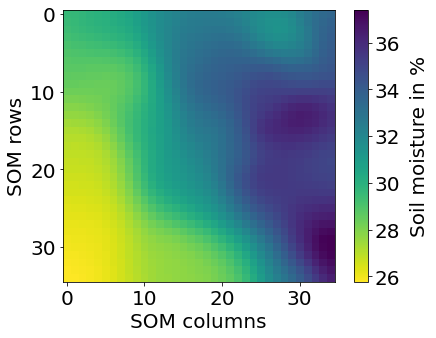

In [8]:
estimation_map = np.squeeze(som.get_estimation_map())
plot_estimation_map(
    estimation_map, cbar_label="Soil moisture in %", cmap="viridis_r")
plt.show()

### Plot SOM histogram

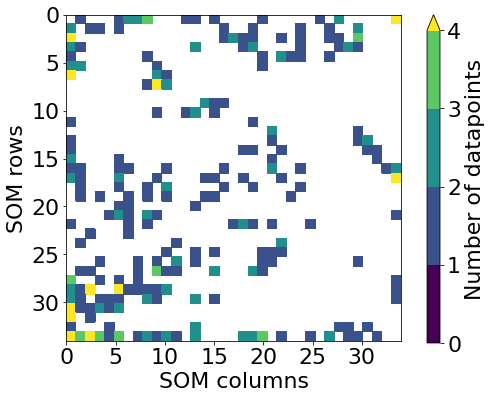

In [9]:
bmu_list = som.get_bmus(X_train.values, som.unsuper_som_)
plot_som_histogram(bmu_list, 35, 35)
plt.show()

### Plot u-matrix

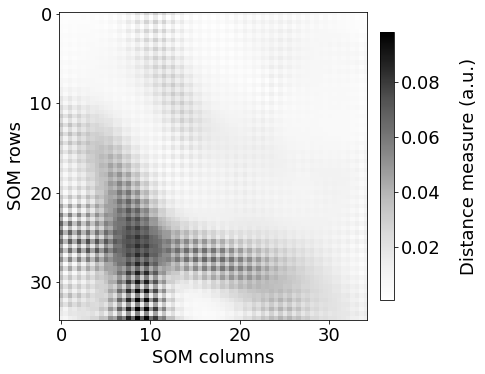

In [10]:
u_matrix = som.get_u_matrix(mode="mean")
plot_umatrix(u_matrix, som.n_rows, som.n_columns)
plt.show()